# Harris County Home Price Estimations


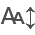

In [2]:
import os
from datetime import datetime

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from itables import init_notebook_mode, show
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

from scipy.stats import randint, uniform

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from load_to_dataframe import load_housing_data, load_mailing_data

init_notebook_mode(all_interactive=True)
%matplotlib inline

# Load Data
In the file **load_to_dataframe.py** there is a function that will load the housing data from the *housing_data.zip* into a data frame. There was some processing of the data so that the CSV would be under 100mb to work with a git repo. Below are the filter that took place. 

* Only houses with improvement type 1001 (single family homes) will be selected
* The date erected must be greater than 1900
* The assessed value must be greater than 0
* the square footage must be greater than 50

In [3]:
df = load_housing_data()

# Haversine Function
The haversine function is used to calculate the distance between two sets of latitude and longitude coordinates. In this case one of the fixed points is the center of downtown Houston (29.760100, -95.370100). The assumption is, the closer to Houston's downtown, the higher the value.

In [4]:
def haversine(lat1, lon1, lat2, lon2):
    # Radius of Earth in miles
    r = 3958.8
    # Convert degrees to radians
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    d_phi = np.radians(lat2 - lat1)
    d_lambda = np.radians(lon2 - lon1)
    # Haversine formula
    a = np.sin(d_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(d_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return r * c


# Define the single point (latitude, longitude) to calculate the distance from
single_point = (29.760100, -95.370100)  # Houston

# Add a new column with distances
df["distance_miles"] = df.apply(
    lambda row: haversine(
        single_point[0], single_point[1], row["latitude"], row["longitude"]
    ),
    axis=1,
)

# Grouping Account Numbers
There are multiple account numbers for properties with multiple buildings, and most of the data is repeated for the different buildings other than the bld_num, date_erected, im_sq_ft, dscr_e, and the perimeter. The rest of the features can have the mean taken and it will be the same number pressent. 
The dscr_e is an ordial field and the average of the buildings will be used. 

In [5]:
df = (
    df.groupby("acct")
    .agg(
        bld_num=("bld_num", "max"),
        date_erected=("date_erected", "min"),
        im_sq_ft=("im_sq_ft", "sum"),
        land_ar=("land_ar", "mean"),
        perimeter=("perimeter", "sum"),
        bedrooms=("bedrooms", "mean"),
        full_bath=("full_bath", "mean"),
        half_bath=("half_bath", "mean"),
        total_rooms=("total_rooms", "mean"),
        dscr_e=("dscr_e", "mean"),
        frame_detached_garage=("frame_detached_garage", "mean"),
        gunite_pool=("gunite_pool", "mean"),
        pool_heater=("pool_heater", "mean"),
        solar_panel=("solar_panel", "mean"),
        brick_garage=("brick_garage", "mean"),
        canopy_residential=("canopy_residential", "mean"),
        frame_abov=("frame_abov", "mean"),
        frame_shed=("frame_shed", "mean"),
        carport_residential=("carport_residential", "mean"),
        foundation_repaired=("foundation_repaired", "mean"),
        cracked_slab=("cracked_slab", "mean"),
        latitude=("latitude", "mean"),
        longitude=("longitude", "mean"),
        distance_miles=("distance_miles", "mean"),
        land_val=("land_val", "mean"),
        bld_val=("bld_val", "mean"),
        assessed_val=("assessed_val", "mean"),
    )
    .reset_index()
)
df["assessed_per_sqft"] = df["assessed_val"] / df["im_sq_ft"]
df

acct  bld_num  date_erected  im_sq_ft  land_ar  perimeter  \
0          20720000014        1          2019      2534   5564.0        452   
1          21440000001        1          2004      2537   5000.0        314   
2          21480000002        1          1917      1496   5000.0        186   
3          21650000007        1          2015      3387   5000.0        578   
4          21650000011        1          2003      1508   6250.0        210   
...                ...      ...           ...       ...      ...        ...   
1095702  1938003804013        1          2003      2117   5250.0        318   
1095703  1938003804014        1          2003      1611   5250.0        184   
1095704  1953050320690        1          1979      2168   6820.0        232   
1095705  1953080320060        1          1983      1723   7575.0        216   
1095706  1955020050280        1          1979      1374   8851.0        250   

         bedrooms  full_bath  half_bath  total_rooms  ...  \
0             3.0        3.0        1.0          6.0  ...   
1             3.0        2.0        1.0          8.0  ...   
2             3.0        1.0        0.0          6.0  ...   
3             3.0        3.0        1.0          6.0  ...   
4             3.0        2.0        0.0          5.0  ...   
...           ...        ...        ...          ...  ...   
1095702       3.0        2.0        1.0          7.0  ...   
1095703       3.0        2.0        0.0          6.0  ...   
1095704       3.0        2.0        0.0          5.0  ...   
1095705       3.0        2.0        0.0          6.0  ...   
1095706       3.0        2.0        1.0          5.0  ...   

         carport_residential  foundation_repaired  cracked_slab   latitude  \
0                        0.0                  0.0           0.0  29.743903   
1                        0.0                  0.0           0.0  29.740005   
2                        0.0                  0.0           0.0  29.742185   
3                        0.0                  0.0           0.0  29.741158   
4                        0.0                  0.0           0.0  29.741294   
...                      ...                  ...           ...        ...   
1095702                  0.0                  0.0           0.0  29.594555   
1095703                  0.0                  0.0           0.0  29.594558   
1095704                  0.0                  0.0           0.0  29.694444   
1095705                  0.0                  0.0           0.0  29.694102   
1095706                  0.0                  0.0           0.0  29.702614   

         longitude  distance_miles  land_val   bld_val  assessed_val  \
0       -95.356534        1.383701  253352.0  451951.0      705303.0   
1       -95.358428        1.554979  200000.0  307658.0      510178.0   
2       -95.361765        1.334974  200000.0    9486.0      209586.0   
3       -95.361889        1.398421  200000.0  523919.0      723919.0   
4       -95.361493        1.398188  225000.0  172034.0      397034.0   
...            ...             ...       ...       ...           ...   
1095702 -95.453635       12.489168   35438.0  233603.0      269041.0   
1095703 -95.453478       12.485174   35438.0  204053.0      239491.0   
1095704 -95.658936       17.914352   54560.0  201010.0      255570.0   
1095705 -95.658271       17.881794   55740.0  173156.0      228896.0   
1095706 -95.673357       18.623451   64580.0  160896.0      225476.0   

         assessed_per_sqft  
0               278.335833  
1               201.094994  
2               140.097594  
3               213.734573  
4               263.285146  
...                    ...  
1095702         127.085971  
1095703         148.659839  
1095704         117.882841  
1095705         132.847359  
1095706         164.101892  

[1095707 rows x 29 columns]

# Price Per Square Foot
This is another metric that I will explore to see if there is a relationship between other values. This data will be cleaned and also a test since any property with 0 square feet will return a divide by zero error, so the row will be dropped.

In [6]:
df["assessed_per_sqft"].describe()

count    1.095707e+06
mean     1.612878e+02
std      7.578459e+01
min      1.785714e+00
25%      1.241208e+02
50%      1.429477e+02
75%      1.695208e+02
max      5.090190e+03
Name: assessed_per_sqft, dtype: float64

In [7]:
df["assessed_val"].describe()

count    1.095707e+06
mean     3.726411e+05
std      4.020768e+05
min      1.000000e+03
25%      2.177715e+05
50%      2.818750e+05
75%      3.887865e+05
max      2.673551e+07
Name: assessed_val, dtype: float64

# Feature Scaling
The features will be scaled to be between 0 and 1

In [8]:
# from sklearn.preprocessing import MinMaxScaler
# columns_to_scale = ['date_erected', 'im_sq_ft', 'land_ar', 'perimeter',
#        'bedrooms', 'full_bath', 'half_bath', 'total_rooms', 'dscr_e',
#        'frame_detached_garage', 'gunite_pool', 'pool_heater', 'solar_panel',
#        'brick_garage', 'canopy_residential', 'frame_abov', 'frame_shed',
#        'carport_residential', 'foundation_repaired', 'cracked_slab',
#        'latitude', 'longitude', 'distance_miles']
# scaler = MinMaxScaler()
# df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [9]:
df.columns

Index(['acct', 'bld_num', 'date_erected', 'im_sq_ft', 'land_ar', 'perimeter',
       'bedrooms', 'full_bath', 'half_bath', 'total_rooms', 'dscr_e',
       'frame_detached_garage', 'gunite_pool', 'pool_heater', 'solar_panel',
       'brick_garage', 'canopy_residential', 'frame_abov', 'frame_shed',
       'carport_residential', 'foundation_repaired', 'cracked_slab',
       'latitude', 'longitude', 'distance_miles', 'land_val', 'bld_val',
       'assessed_val', 'assessed_per_sqft'],
      dtype='object')

In [10]:
df.head()

acct  bld_num  date_erected  im_sq_ft  land_ar  perimeter  bedrooms  \
0  20720000014        1          2019      2534   5564.0        452       3.0   
1  21440000001        1          2004      2537   5000.0        314       3.0   
2  21480000002        1          1917      1496   5000.0        186       3.0   
3  21650000007        1          2015      3387   5000.0        578       3.0   
4  21650000011        1          2003      1508   6250.0        210       3.0   

   full_bath  half_bath  total_rooms  ...  carport_residential  \
0        3.0        1.0          6.0  ...                  0.0   
1        2.0        1.0          8.0  ...                  0.0   
2        1.0        0.0          6.0  ...                  0.0   
3        3.0        1.0          6.0  ...                  0.0   
4        2.0        0.0          5.0  ...                  0.0   

   foundation_repaired  cracked_slab   latitude  longitude  distance_miles  \
0                  0.0           0.0  29.743903 -95.356534        1.383701   
1                  0.0           0.0  29.740005 -95.358428        1.554979   
2                  0.0           0.0  29.742185 -95.361765        1.334974   
3                  0.0           0.0  29.741158 -95.361889        1.398421   
4                  0.0           0.0  29.741294 -95.361493        1.398188   

   land_val   bld_val  assessed_val  assessed_per_sqft  
0  253352.0  451951.0      705303.0         278.335833  
1  200000.0  307658.0      510178.0         201.094994  
2  200000.0    9486.0      209586.0         140.097594  
3  200000.0  523919.0      723919.0         213.734573  
4  225000.0  172034.0      397034.0         263.285146  

[5 rows x 29 columns]

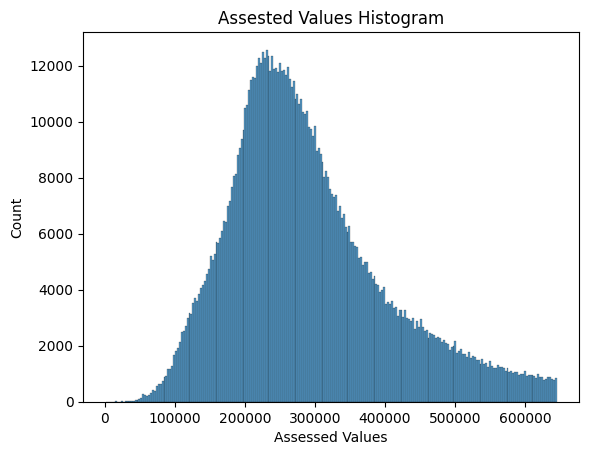

In [15]:
y = df["assessed_val"]
sns.histplot(y)
# plt.hist(y,bins=50, normed = True)
plt.xlabel("Assessed Values")
plt.ylabel("Count")
plt.title("Assested Values Histogram")
plt.show()

# Reduce data set to a manageable size
The current data set is over 1.1M rows. This would take **DAYS** to train a model on a regular computer. This is after the initial filtering when extracting the data from the SQLite database.

To reduce the number of houses and remove outliers I will use the inner quartile range to remove the outliers.


In [16]:
print(f"There are {df.shape[0]:,} rows and {df.shape[1]} columns in the df Data Frame.")

There are 1,001,600 rows and 29 columns in the df Data Frame.


In [17]:
# IQR
Q1 = df["assessed_val"].quantile(0.25)
Q3 = df["assessed_val"].quantile(0.75)
IQR = Q3 - Q1

lower_iqr = Q1 - 1.5 * IQR
upper_iqr = Q3 + 1.5 * IQR
print(f"Lower IQR: {lower_iqr} | Upper IQR: {upper_iqr}")

df = df[(df["assessed_val"] <= upper_iqr)]

Lower IQR: 5579.625 | Upper IQR: 556676.625


In [18]:
df["assessed_val"].describe()

count    969541.000000
mean     280775.102572
std      100273.795897
min        1000.000000
25%      210348.000000
50%      266029.000000
75%      339597.000000
max      556674.000000
Name: assessed_val, dtype: float64

In [19]:
y = df["assessed_val"]
y_per_sqft = df["assessed_per_sqft"]

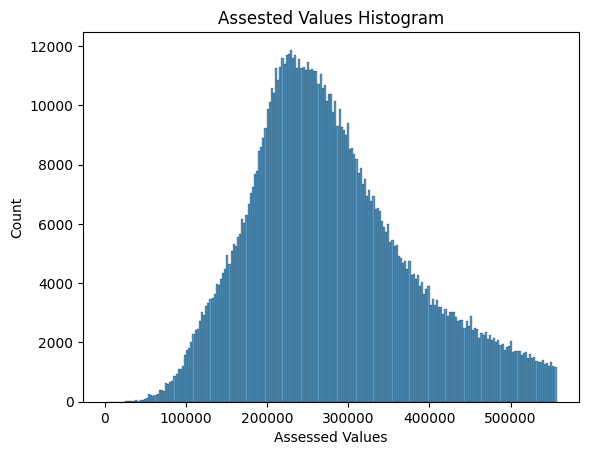

In [20]:
sns.histplot(y)
plt.xlabel("Assessed Values")
plt.ylabel("Count")
plt.title("Assested Values Histogram")
plt.show()

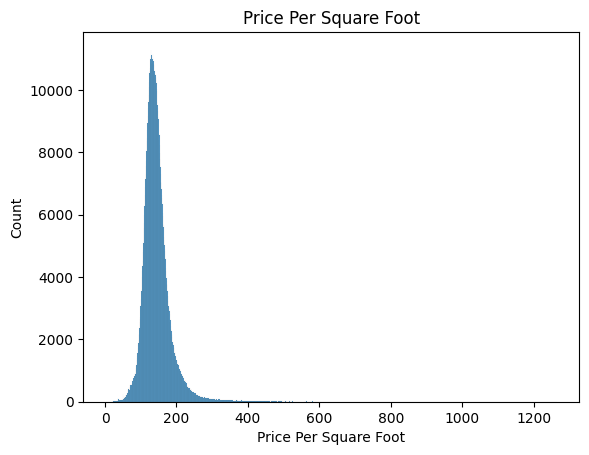

In [21]:
sns.histplot(y_per_sqft)
plt.xlabel("Price Per Square Foot")
plt.ylabel("Count")
plt.title("Price Per Square Foot")
plt.show()

## Sample Size Reduction
Since the data set is still over 1M homes, we need to reduce the size to create a model. I will use 10 thousand random samples from the full data frame.

In [16]:
sample_df = df.sample(n=10000, random_state=40)
show(sample_df)
# sample_df.to_csv("sample_housing_data.csv")

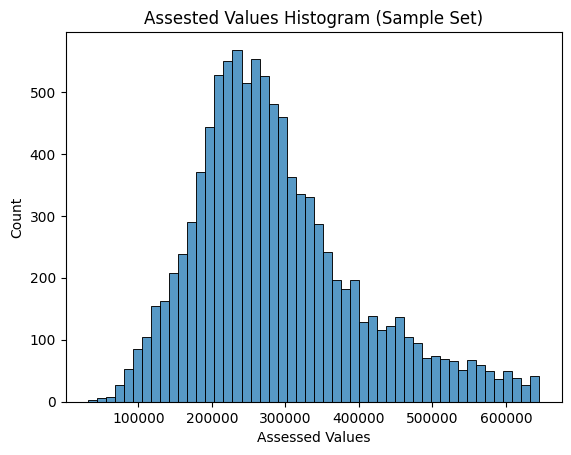

In [17]:
sns.histplot(sample_df["assessed_val"])
plt.xlabel("Assessed Values")
plt.ylabel("Count")
plt.title("Assested Values Histogram (Sample Set)")
plt.show()

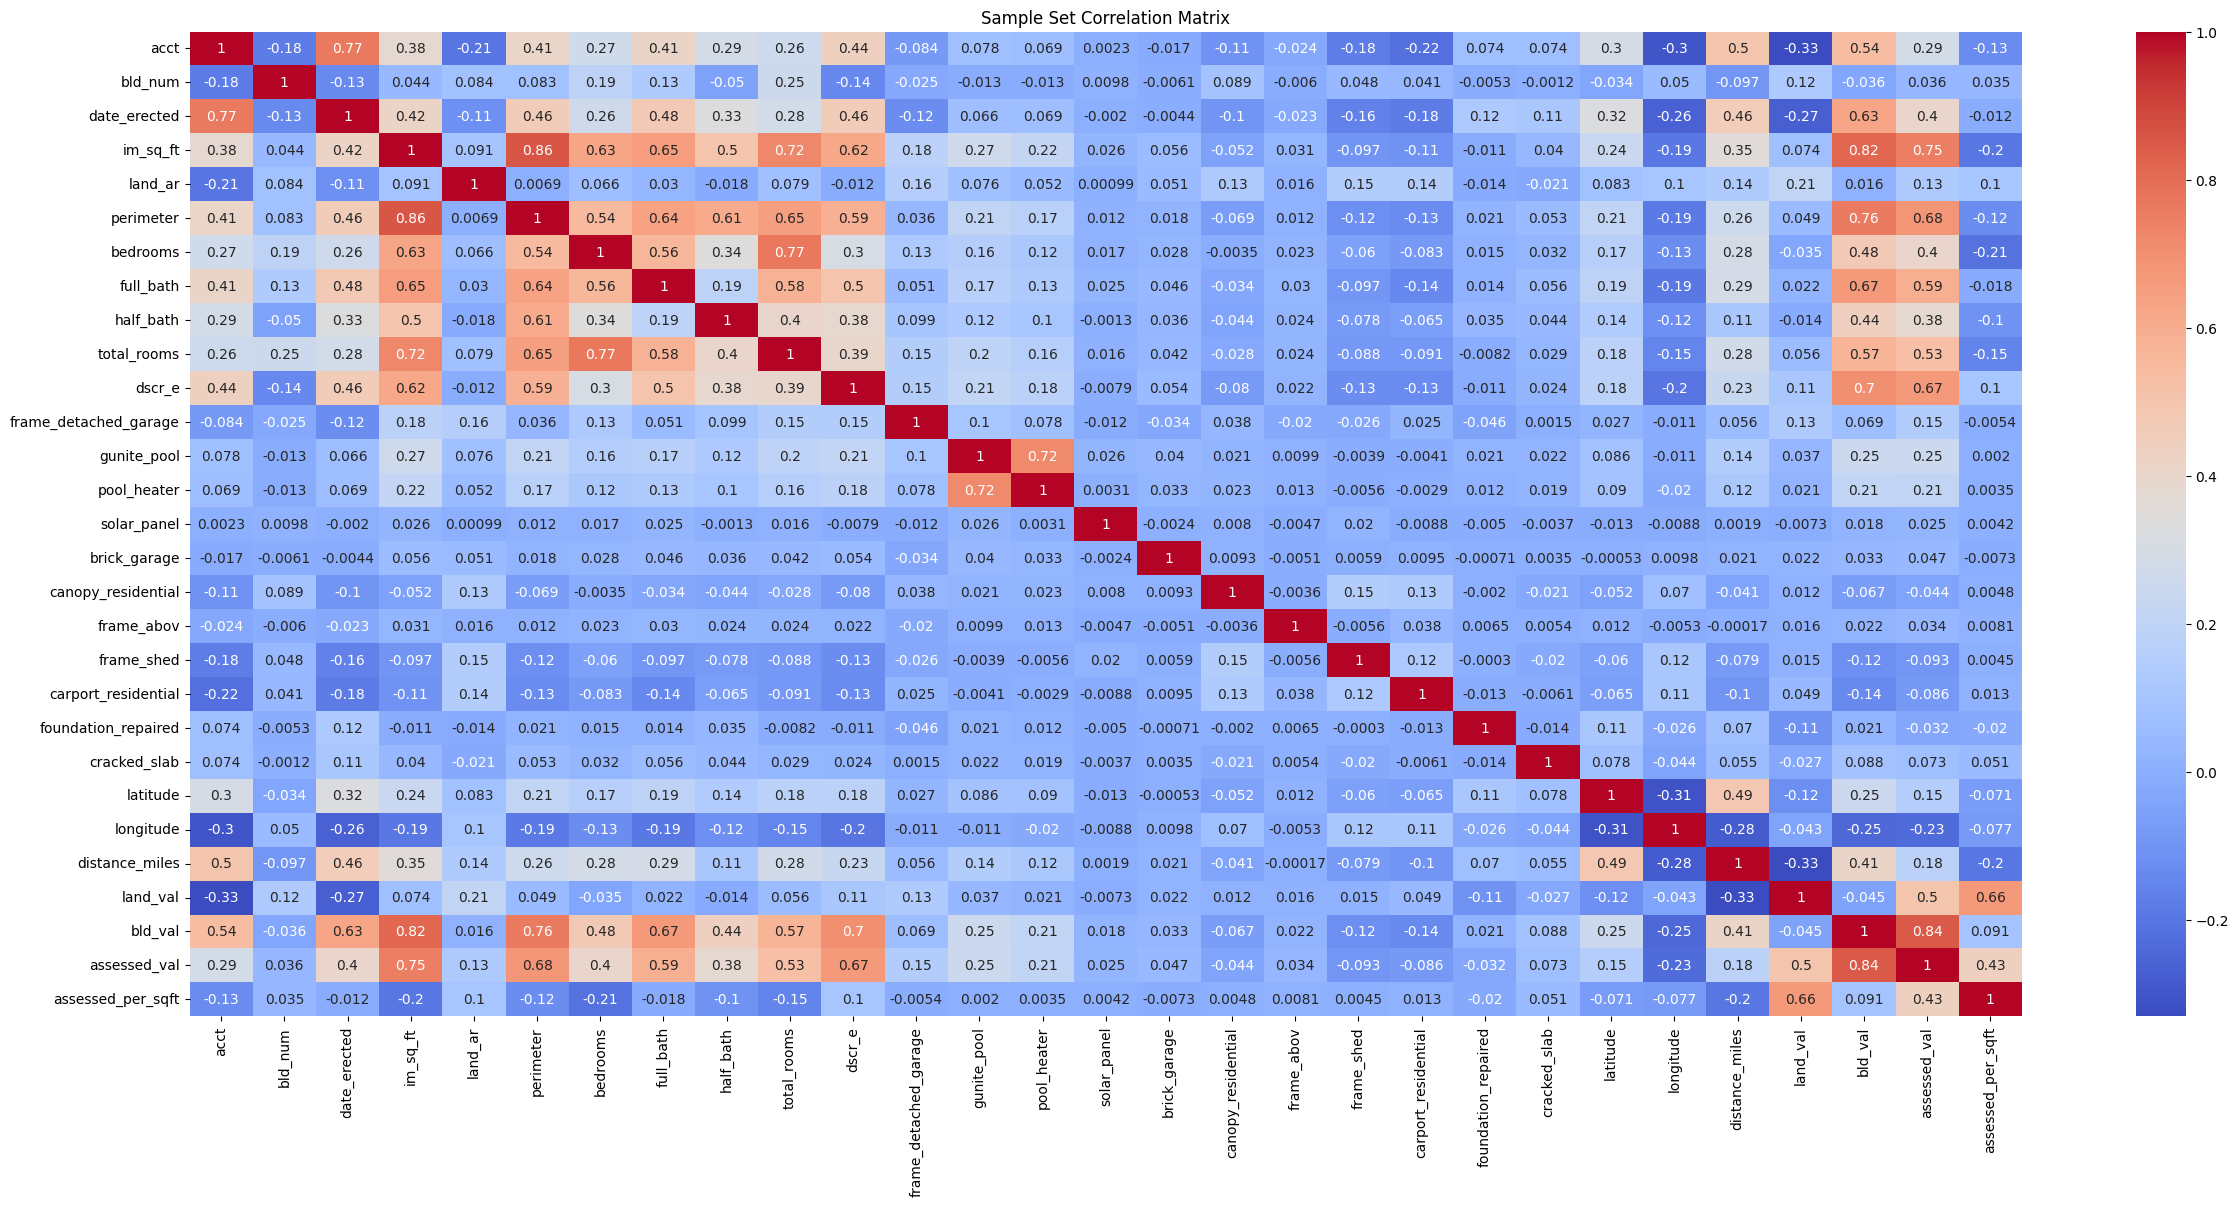

In [18]:
corr_matrix = sample_df.corr()
plt.figure(figsize=(25, 12))
sns.heatmap(data=corr_matrix, annot=True, cmap="coolwarm")
plt.tight_layout()
plt.title("Sample Set Correlation Matrix")
plt.show()

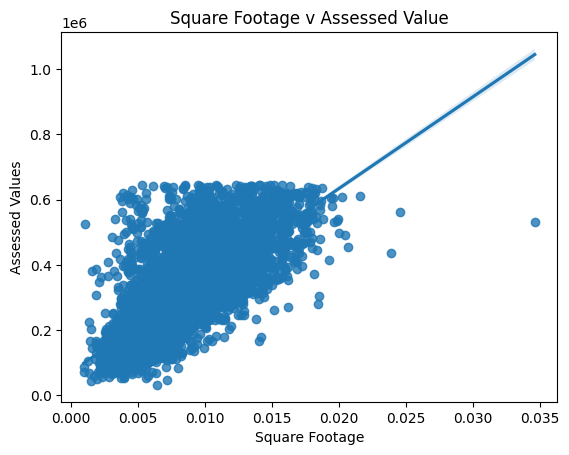

In [19]:
sns.regplot(sample_df, x="im_sq_ft", y="assessed_val")
plt.xlabel("Square Footage")
plt.ylabel("Assessed Values")
plt.title("Square Footage v Assessed Value")
plt.show()

# Create the features as X

In [20]:
X = sample_df[
    [
        "date_erected",
        "im_sq_ft",
        "land_ar",
        "perimeter",
        "bedrooms",
        "full_bath",
        "half_bath",
        "total_rooms",
        "latitude",
        "longitude",
        "dscr_e",
        "frame_detached_garage",
        "gunite_pool",
        "pool_heater",
        "brick_garage",
        "canopy_residential",
        "frame_abov",
        "frame_shed",
        "carport_residential",
        "foundation_repaired",
        "cracked_slab",
        "distance_miles",
    ]
]

y = sample_df["assessed_val"]
print(f"There are {X.shape[1] + 1} features in total.")

There are 23 features in total.


# Train, Test, Split

In [21]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [22]:
x_train.describe()

date_erected     im_sq_ft      land_ar    perimeter     bedrooms  \
count   7000.000000  7000.000000  7000.000000  7000.000000  7000.000000   
mean       0.690432     0.007702     0.001549     0.014720     0.007451   
std        0.192802     0.002994     0.002098     0.002758     0.001644   
min        0.113821     0.000956     0.000000     0.009405     0.000000   
25%        0.552846     0.005540     0.001014     0.012703     0.006682   
50%        0.674797     0.007192     0.001252     0.013924     0.006682   
75%        0.853659     0.009403     0.001574     0.016489     0.008909   
max        0.991870     0.034641     0.073963     0.029497     0.026726   

         full_bath    half_bath  total_rooms     latitude    longitude  ...  \
count  7000.000000  7000.000000  7000.000000  7000.000000  7000.000000  ...   
mean      0.004851     0.018056     0.007340     0.505341     0.511922  ...   
std       0.001453     0.021900     0.001599     0.216994     0.201681  ...   
min       0.000000     0.000000     0.002179     0.004305     0.025991  ...   
25%       0.004854     0.000000     0.006536     0.316573     0.352010  ...   
50%       0.004854     0.000000     0.006536     0.507029     0.504116  ...   
75%       0.004854     0.043478     0.008715     0.682237     0.682817  ...   
max       0.019417     0.130435     0.027233     0.995458     0.998796  ...   

       gunite_pool  pool_heater  brick_garage  canopy_residential  \
count  7000.000000  7000.000000   7000.000000         7000.000000   
mean      0.001084     0.000934      0.000559            0.001607   
std       0.004601     0.005522      0.005361            0.006818   
min       0.000000     0.000000      0.000000            0.000000   
25%       0.000000     0.000000      0.000000            0.000000   
50%       0.000000     0.000000      0.000000            0.000000   
75%       0.000000     0.000000      0.000000            0.000000   
max       0.055078     0.074074      0.173812            0.118719   

        frame_abov   frame_shed  carport_residential  foundation_repaired  \
count  7000.000000  7000.000000          7000.000000          7000.000000   
mean      0.000117     0.004114             0.000948             0.996649   
std       0.002504     0.017171             0.005446             0.026101   
min       0.000000     0.000000             0.000000             0.623548   
25%       0.000000     0.000000             0.000000             1.000000   
50%       0.000000     0.000000             0.000000             1.000000   
75%       0.000000     0.000000             0.000000             1.000000   
max       0.093602     0.357143             0.163763             1.000000   

       cracked_slab  distance_miles  
count   7000.000000     7000.000000  
mean       0.997986        0.350512  
std        0.018837        0.157544  
min        0.562548        0.000524  
25%        1.000000        0.226295  
50%        1.000000        0.357645  
75%        1.000000        0.476510  
max        1.000000        0.910618  

[8 rows x 22 columns]

In [23]:
y_train.describe()

count      7000.000000
mean     287651.028429
std      111941.872241
min       31836.000000
25%      211187.250000
50%      267550.500000
75%      343657.500000
max      644098.000000
Name: assessed_val, dtype: float64

# Extra Random Trees
Using GridSearchCV for hyperparameter tuning. If this is done, it will increase the model's runtime to take several hours, and depending on the sample size and parameters, the computer may need up to 64 GB of RAM to process the models. If the computer has 32 GB, ensure the n_jobs = 4 or less. If the computer has 16gb of ram put n_jobs=1. n_jobs is the parallel jobs going simultaneously and consuming more resources. 

In [24]:
X.shape[1]

22

In [25]:


etr = ExtraTreesRegressor(random_state=42)


param_grid = {
    "n_estimators": randint(100, 4000),
    "max_depth": randint(1, 50),
    "min_samples_leaf": randint(1, 10),
    "min_samples_split": randint(2, 20),
    "max_features": uniform(0.1, 0.9),

}


# etr_cv = GridSearchCV(
#     etr, param_grid, cv=5, n_jobs=-1, scoring="neg_mean_squared_error"
# )

etr_cv = HalvingRandomSearchCV(
    estimator=etr,
    param_distributions=param_grid,
    factor=2,
    random_state=42,
    cv=3,
    n_jobs=-1,
    scoring="neg_mean_squared_error",
    verbose=2,
)


etr_cv.fit(x_train, y_train)

n_iterations: 11
n_required_iterations: 11
n_possible_iterations: 11
min_resources_: 6
max_resources_: 7000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 1166
n_resources: 6
Fitting 3 folds for each of 1166 candidates, totalling 3498 fits


c:\Users\Blake\Documents\Github\HouseProtestValues\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 1
n_candidates: 583
n_resources: 12
Fitting 3 folds for each of 583 candidates, totalling 1749 fits
----------
iter: 2
n_candidates: 292
n_resources: 24
Fitting 3 folds for each of 292 candidates, totalling 876 fits
----------
iter: 3
n_candidates: 146
n_resources: 48
Fitting 3 folds for each of 146 candidates, totalling 438 fits
----------
iter: 4
n_candidates: 73
n_resources: 96
Fitting 3 folds for each of 73 candidates, totalling 219 fits
----------
iter: 5
n_candidates: 37
n_resources: 192
Fitting 3 folds for each of 37 candidates, totalling 111 fits
----------
iter: 6
n_candidates: 19
n_resources: 384
Fitting 3 folds for each of 19 candidates, totalling 57 fits
----------
iter: 7
n_candidates: 10
n_resources: 768
Fitting 3 folds for each of 10 candidates, totalling 30 fits
----------
iter: 8
n_candidates: 5
n_resources: 1536
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 9
n_candidates: 3
n_resources: 3072
Fitting 3 folds for each of 

HalvingRandomSearchCV(cv=3, estimator=ExtraTreesRegressor(random_state=42),
                      factor=2, n_jobs=-1,
                      param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002205DFE7110>,
                                           'max_features': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002205EDD8C20>,
                                           'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002205DFE7390>,
                                           'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002205E03C050>,
                                           'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002205EDD8AD0>},
                      random_state=42, scoring='neg_mean_squared_error',
                      verbose=2)

In [26]:
# etr = ExtraTreesRegressor(random_state=42)
# param_grid = {
#     "n_estimators": [1300, 1400, 1500],
#     "min_samples_leaf": [1, 2, 3],
#     "min_samples_split": [2, 5, 6, 7],
#     "max_features": [x for x in range(1, X.shape[1])],
#     "criterion": ["squared_error"],
#     "warm_start": [False, True],
# }
# etr_cv = GridSearchCV(
#     etr, param_grid, cv=5, n_jobs=-1, scoring="neg_mean_squared_error"
# )
# etr_cv.fit(x_train, y_train)

In [27]:
etr_cv.best_score_

np.float64(-2712665625.64715)

In [28]:
etr_cv.best_params_

{'max_depth': 40,
 'max_features': np.float64(0.7102145373031572),
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 315}

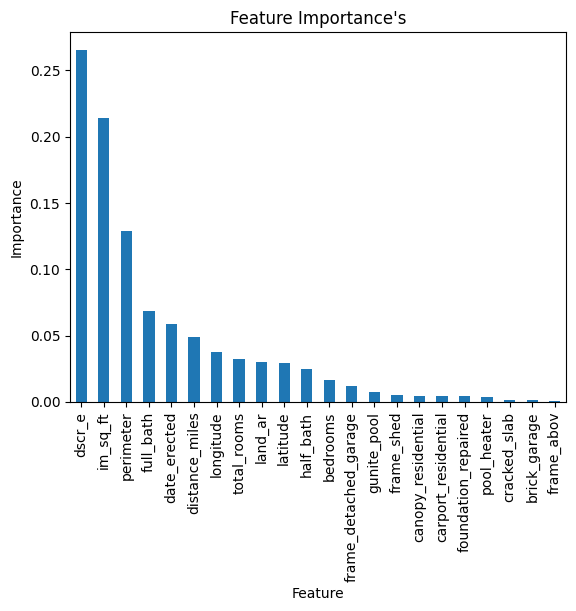

In [29]:
feature_names = [f"{i}" for i in X.columns]
best_model = etr_cv.best_estimator_
feature_importances = best_model.feature_importances_

# Rank the features by importance
importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances}
).sort_values(by="Importance", ascending=False)

# Graph the importance of the features
importance_df.plot(kind="bar", x="Feature", y="Importance", legend=False)
plt.title("Feature Importance's")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()

In [30]:
ert_cv_results = pd.DataFrame(etr_cv.cv_results_)
ert_cv_results["param_n_estimators"] = ert_cv_results["param_n_estimators"].astype(
    "category"
)
ert_cv_results

iter  n_resources  mean_fit_time  std_fit_time  mean_score_time  \
0        0            6       2.355046      0.040340         0.174918   
1        0            6       3.847267      0.919015         0.225900   
2        0            6       3.028896      0.395343         0.173449   
3        0            6       0.677881      0.190812         0.054746   
4        0            6       0.679900      0.087599         0.061522   
...    ...          ...            ...           ...              ...   
2331     9         3072       4.178366      0.029221         0.203444   
2332     9         3072       1.495255      0.036884         0.065901   
2333     9         3072       2.354378      0.034246         0.100179   
2334    10         6144       3.635839      0.016780         0.169180   
2335    10         6144       2.456701      0.018977         0.106865   

      std_score_time  param_max_depth  param_max_features  \
0           0.011973               39            0.816889   
1           0.008934               19            0.189977   
2           0.010704               24            0.685800   
3           0.026960               44            0.944697   
4           0.021805               22            0.106360   
...              ...              ...                 ...   
2331        0.002851               29            0.476560   
2332        0.001611               40            0.710215   
2333        0.001187               19            0.552823   
2334        0.001336               19            0.552823   
2335        0.000865               40            0.710215   

      param_min_samples_leaf  param_min_samples_split  ... split1_test_score  \
0                          8                        8  ...     -6.918746e+09   
1                          8                        5  ...     -6.918746e+09   
2                          5                        3  ...     -6.918746e+09   
3                          2                        2  ...     -2.684766e+09   
4                          9                       18  ...     -6.918746e+09   
...                      ...                      ...  ...               ...   
2331                       1                        8  ...     -2.820871e+09   
2332                       1                        7  ...     -2.800004e+09   
2333                       1                        6  ...     -2.830237e+09   
2334                       1                        6  ...     -2.578748e+09   
2335                       1                        7  ...     -2.526194e+09   

     split2_test_score  mean_test_score  std_test_score  rank_test_score  \
0        -3.550822e+10    -1.754632e+10    1.277194e+10              722   
1        -3.550822e+10    -1.754632e+10    1.277194e+10             1259   
2        -3.550822e+10    -1.754632e+10    1.277194e+10             1010   
3        -2.009843e+10    -1.099840e+10    7.130814e+09              239   
4        -3.550822e+10    -1.754632e+10    1.277194e+10              830   
...                ...              ...             ...              ...   
2331     -3.609660e+09    -3.191289e+09    3.238023e+08                5   
2332     -3.559746e+09    -3.160987e+09    3.113115e+08                3   
2333     -3.559694e+09    -3.164113e+09    3.009792e+08                4   
2334     -2.921721e+09    -2.751129e+09    1.400238e+08                2   
2335     -2.892087e+09    -2.712666e+09    1.494584e+08                1   

      split0_train_score  split1_train_score  split2_train_score  \
0          -7.141231e+08       -3.951470e+09       -1.230117e+10   
1          -7.141231e+08       -3.951470e+09       -1.230117e+10   
2          -7.141231e+08       -3.951470e+09       -1.230117e+10   
3          -7.141231e+08       -8.171219e+08       -6.399984e+09   
4          -7.141231e+08       -3.951470e+09       -1.230117e+10   
...                  ...                 ...                 ...   
2331       -6.671946e+08       -6.669748e+08  

# Savings the model
The model will be save to the hard drive so it can be used later without having to run the entire ExtraTreesRegression model again. 

In [31]:
# Define the folder name
folder_name = "Models"

# Check if the folder exists, and create it if it doesn't
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")

# Get the current date
current_date = datetime.now()

# Format the date as YYYYmmdd
formatted_date = current_date.strftime("%Y%m%d_%H%M")

joblib.dump(etr_cv, f"Models/etc_iqr_{formatted_date}_.pkl", compress=("xz", 3))

Folder 'Models' already exists.


['Models/etc_iqr_20241205_0848_.pkl']

## Analysis of testing data

In [32]:
etr_pred = etr_cv.predict(x_test)
etr_mae = mean_absolute_error(y_test, etr_pred)
etr_mse = mean_squared_error(y_test, etr_pred)
etr_r2 = r2_score(y_test, etr_pred)
print(f"MAE: {etr_mae}\nMSE: {etr_mse}\nR Squared: {etr_r2}\n")

MAE: 32530.5254595772
MSE: 2424142224.2492375
R Squared: 0.8096272520720915



In [33]:
actual = y_test.to_list()
predicted = etr_cv.predict(x_test)
etc_residuals = pd.DataFrame({"actual": actual, "predicted": predicted})
etc_residuals["residuals"] = etc_residuals["actual"] - etc_residuals["predicted"]

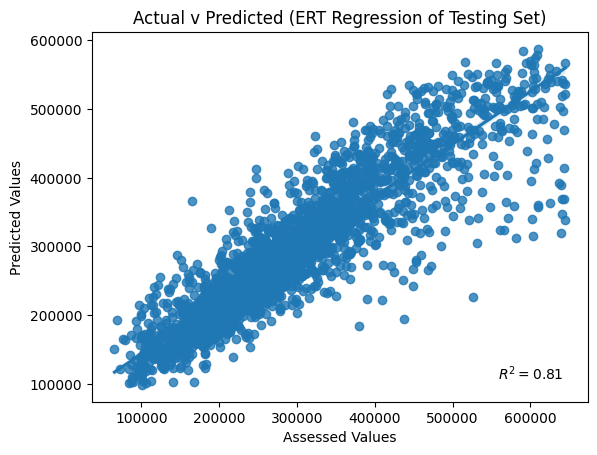

In [34]:
sns.regplot(etc_residuals, x="actual", y="predicted")
plt.xlabel("Assessed Values")
plt.ylabel("Predicted Values")
plt.title("Actual v Predicted (ERT Regression of Testing Set)")

plt.text(
    0.95,
    0.05,
    f"$R^2 = {etr_r2:.2f}$",
    horizontalalignment="right",
    verticalalignment="bottom",
    transform=plt.gca().transAxes,
    fontsize=10,
)
plt.show()

# Residual Analysis

In [35]:
y_train_pred = etr_cv.predict(x_train)
y_test_pred = etr_cv.predict(x_test)

In [36]:
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

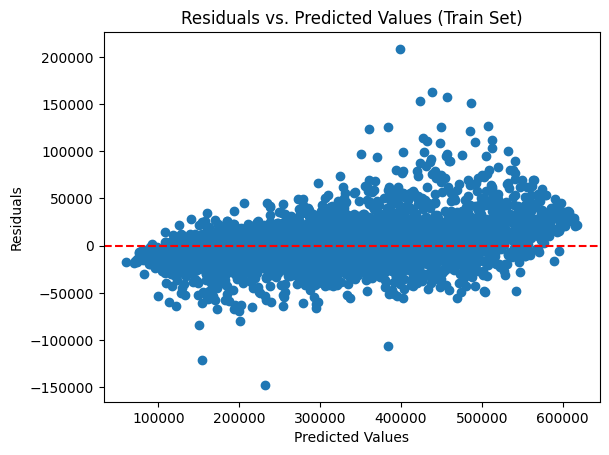

In [37]:
# Train set residuals
plt.scatter(y_train_pred, train_residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values (Train Set)")
plt.show()

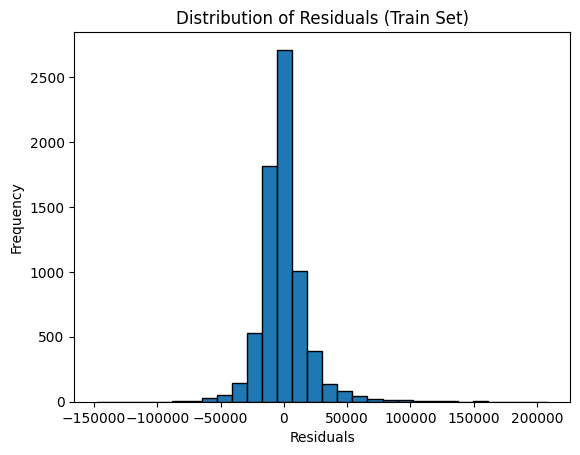

In [38]:
plt.hist(train_residuals, bins=30, edgecolor="k")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Train Set)")
plt.show()

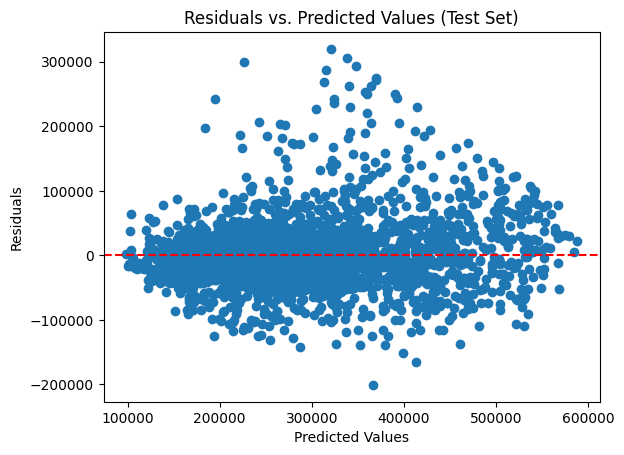

In [39]:
# Test set residuals
plt.scatter(y_test_pred, test_residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values (Test Set)")
plt.show()

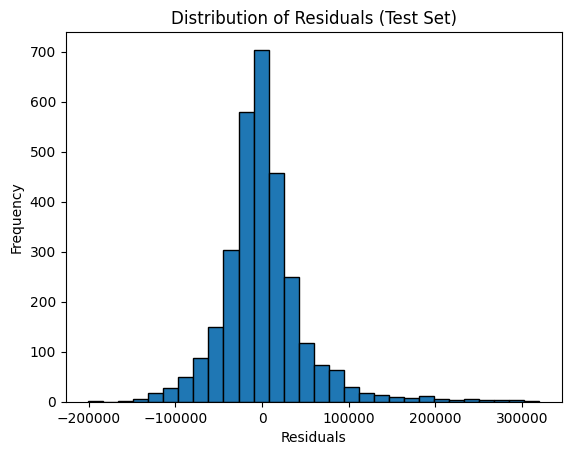

In [40]:
plt.hist(test_residuals, bins=30, edgecolor="k")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Test Set)")
plt.show()

In [41]:
from scipy.stats import shapiro

stat, p = shapiro(test_residuals)
if p > 0.05:
    print(f"Residuals are normally distributed (p > 0.05, p={p}) .")
else:
    print(f"Residuals are not normally distributed (p <= 0.05, p={p}).")

Residuals are not normally distributed (p <= 0.05, p=4.41672534701004e-42).


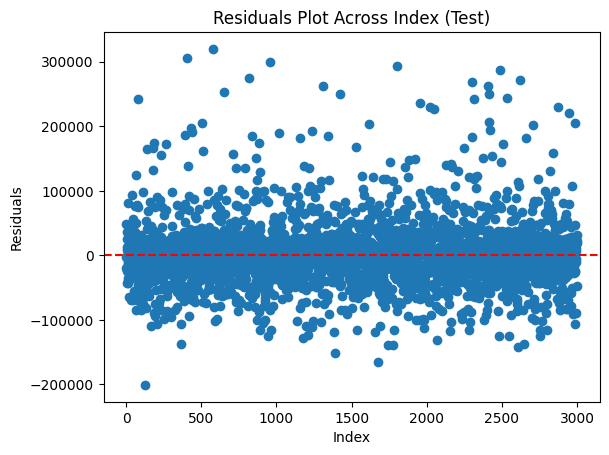

In [42]:
plt.scatter(range(len(y_test)), test_residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.title("Residuals Plot Across Index (Test)")
plt.show()

## Z-Score of the outliers
These indexes are results that are stastically different from the models prediction and may need to be indivially reviewed. 

In [43]:
import numpy as np

z_scores = np.abs((test_residuals - np.mean(test_residuals)) / np.std(test_residuals))
outliers = np.where(z_scores > 3)
print(f"Outlier indices: {outliers}")

Outlier indices: (array([  82,  124,  141,  179,  185,  234,  264,  390,  405,  431,  438,
        507,  510,  575,  654,  712,  818,  837,  861,  883,  955, 1016,
       1154, 1234, 1307, 1344, 1390, 1422, 1531, 1613, 1676, 1801, 1921,
       1953, 2020, 2047, 2246, 2301, 2302, 2317, 2377, 2410, 2413, 2416,
       2421, 2436, 2485, 2505, 2533, 2617, 2662, 2708, 2842, 2875, 2943,
       2984]),)


In [44]:
from statsmodels.api import OLS
import statsmodels.api as sm

model_ols = sm.OLS(y_train, sm.add_constant(x_train)).fit()
influence = model_ols.get_influence()
cooks_d = influence.cooks_distance

In [45]:
y_test.size

3000

## Gradient Boosting Regression

Gradient boosting is another ensemble algorithm that can be used much like Extra Random Trees. It differs in the way that it makes the trees. In gradient boosting new trees are added to correct errors of the previous tress in a sequential manner, while extra random trees builds tress independently by randomly selecting features and split points at each node, which makes it less prone to overfitting compared to gradient boosting which can be more sensitive to overfitting.

In [46]:
gbr = GradientBoostingRegressor(random_state=42)
param_grid = {
    "n_estimators": [4000],
    "learning_rate": [0.01],
    "max_depth": [5],
    "min_samples_split": [3],
    "min_samples_leaf": [1],
    "max_features": [10],
    "warm_start": [True],
    "criterion": ["squared_error"],
}
gbr_cv = GridSearchCV(
    gbr, param_grid, cv=5, n_jobs=-1, scoring="neg_mean_squared_error"
)

In [47]:
gbr_cv.fit(x_train, y_train)
gbr_pred = gbr_cv.predict(x_test)

In [48]:
gbr_mae = mean_absolute_error(y_test, gbr_pred)
gbr_mse = mean_squared_error(y_test, gbr_pred)
gbr_r2 = r2_score(y_test, gbr_pred)
print(f"MAE: {gbr_mae}\nMSE: {gbr_mse}\nR Squared: {gbr_r2}\n")

MAE: 28351.13533064873
MSE: 1817883507.9914818
R Squared: 0.8572379642715292



In [49]:
gbr_cv.best_params_

{'criterion': 'squared_error',
 'learning_rate': 0.01,
 'max_depth': 5,
 'max_features': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 4000,
 'warm_start': True}

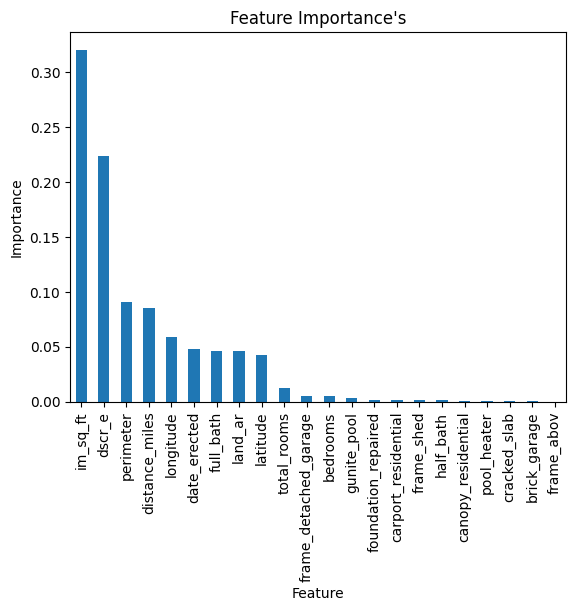

In [50]:
feature_names = [f"{i}" for i in X.columns]
best_model = gbr_cv.best_estimator_
feature_importances = best_model.feature_importances_

# Rank the features by importance
importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances}
).sort_values(by="Importance", ascending=False)

# Graph the importance of the features
importance_df.plot(kind="bar", x="Feature", y="Importance", legend=False)
plt.title("Feature Importance's")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()

In [51]:
gbr_cv.best_score_

np.float64(-1790158995.298844)

In [52]:
# joblib.dump(gbr_cv, "Models/gbr_all_data.pkl")
joblib.dump(gbr_cv, f"Models/gbr_iqr_{formatted_date}_.pkl", compress=('xz',3))

# load
# joblib.load('gbr.pkl')

['Models/gbr_iqr_20241205_0848_.pkl']

In [53]:
gbr_residual_df = pd.DataFrame(
    {
        "actual": actual,
        "predicted": gbr_pred,
    }
)
gbr_residual_df["residuals"] = gbr_residual_df["actual"] - gbr_residual_df["predicted"]

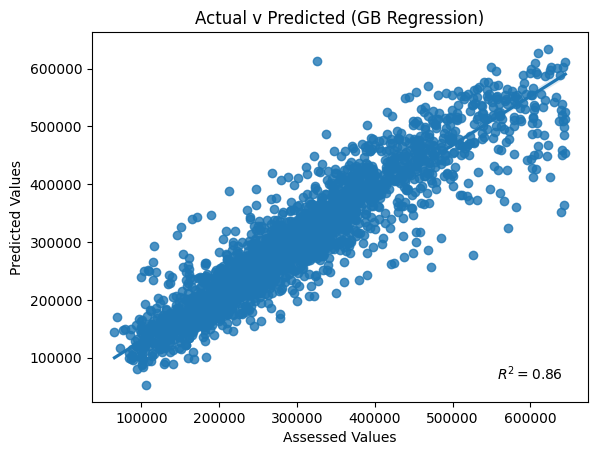

In [54]:
sns.regplot(gbr_residual_df, x="actual", y="predicted")
plt.xlabel("Assessed Values")
plt.ylabel("Predicted Values")
plt.title("Actual v Predicted (GB Regression)")

plt.text(
    0.95,
    0.05,
    f"$R^2 = {gbr_r2:.2f}$",
    horizontalalignment="right",
    verticalalignment="bottom",
    transform=plt.gca().transAxes,
    fontsize=10,
)
plt.show()

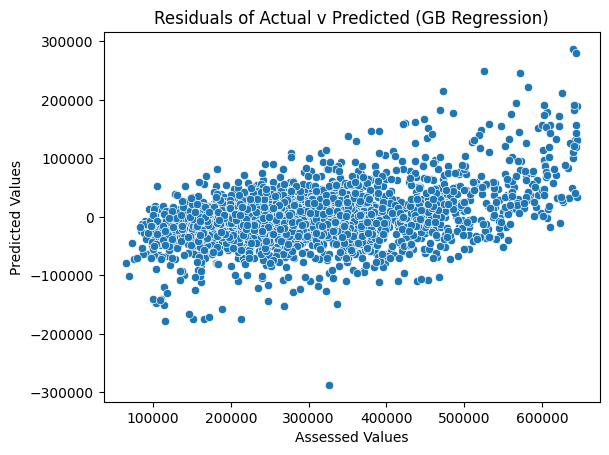

In [55]:
sns.scatterplot(gbr_residual_df, x="actual", y="residuals")
plt.xlabel("Assessed Values")
plt.ylabel("Predicted Values")
plt.title("Residuals of Actual v Predicted (GB Regression)")
plt.show()

# Apply model to entire dataset
The model was created with a random subset of the data to reduce the training time. This will apply the model to the rest of the dataset.

In [56]:
X = df[
    [
        "date_erected",
        "im_sq_ft",
        "land_ar",
        "perimeter",
        "bedrooms",
        "full_bath",
        "half_bath",
        "total_rooms",
        "latitude",
        "longitude",
        "dscr_e",
        "frame_detached_garage",
        "gunite_pool",
        "pool_heater",
        "brick_garage",
        "canopy_residential",
        "frame_abov",
        "frame_shed",
        "carport_residential",
        "foundation_repaired",
        "cracked_slab",
        "distance_miles",
    ]
]
df["ert_predicted"] = etr_cv.predict(X)
df["gbr_predicted"] = gbr_cv.predict(X)

C:\Users\Blake\AppData\Local\Temp\ipykernel_30668\349939507.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ert_predicted"] = etr_cv.predict(X)
C:\Users\Blake\AppData\Local\Temp\ipykernel_30668\349939507.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["gbr_predicted"] = gbr_cv.predict(X)


In [57]:
df[["assessed_val", "ert_predicted", "gbr_predicted"]]

assessed_val  ert_predicted  gbr_predicted
1            510178.0  484119.026667  504693.176843
2            209586.0  228812.460794  246313.838452
4            397034.0  281254.768254  318210.185983
5            239318.0  254341.462804  256000.262410
7            206372.0  271101.459735  231053.692331
...               ...            ...            ...
1095586      269041.0  274077.939048  260318.046208
1095587      239491.0  236635.404074  228731.963985
1095588      255570.0  257801.113333  253561.883642
1095589      228896.0  233959.782419  223291.562189
1095590      225476.0  224084.241905  214064.267069

[1001495 rows x 3 columns]

# Merge Mailing Address
Merge the Mailing Address information with the properties to protest.

**Need to redo the import of the mailing data from a single file if the database does not exist.**

In [58]:
mail_addr = load_mailing_data()
df = df.merge(mail_addr, how="left", left_on="acct", right_on="acct")

# Properties that should be protested

In [59]:
protest_ert = df.query("assessed_val <= ert_predicted")
protest_gbr = df.query("assessed_val <= gbr_predicted")

In [60]:
total = df.shape[0]
count_ert = protest_ert.shape[0]
count_gbr = protest_gbr.shape[0]
print(
    f"Total Accounts: {total}, Extra Trees: {count_ert}, Gradient Boosting Regressor: {count_gbr}"
)

Total Accounts: 1001495, Extra Trees: 537748, Gradient Boosting Regressor: 517360


In [61]:
# Define the folder name
folder_name = "Output"

# Check if the folder exists, and create it if it doesn't
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")


def output_dataframe_csv(df_name, name):
    df_name.to_csv(f"Output/{name}.csv", index=False)

Folder 'Output' already exists.


In [62]:
output_dataframe_csv(df, "All_Data_IQR")
output_dataframe_csv(protest_ert, "Protest_Data_Extra_Trees_IQR")
output_dataframe_csv(protest_gbr, "Protest_Data_Extra_GBR_IQR")

## Proportions of homes to be send advertiments

In [63]:
percent_etr = (count_ert / total) * 100
percent_gbr = (count_gbr / total) * 100
print(
    f"Extra Random Trees regression model predicts that {percent_etr:.2f}% of total accounts should be protested.\nGradient Boosting Regressor: {percent_gbr:.2f}% of total accounts."
)

Extra Random Trees regression model predicts that 53.69% of total accounts should be protested.
Gradient Boosting Regressor: 51.66% of total accounts.
